Starting Monte Carlo Simulation...
Simulations: 50000
Locations: 6
Strategies: 6
--------------------------------------------------
Simulating Hotung...
Simulating Tower...
Simulating Hodgedon...
Simulating Kindlevan...
Simulating Dewick...
Simulating Carmichael...

=== AVERAGE DAILY PROFIT MATRIX ($) ===
Strategy             1         2         3         4         5         6
Dining Place                                                            
Carmichael    30546.70  44290.05  44186.28  36505.22  45130.27  50456.05
Dewick        30552.18  44303.96  44203.69  36509.62  45127.49  50479.50
Hodgedon      17103.17  22251.46  22075.42  18296.16  19722.19  21654.01
Hotung         3500.90   1404.62   2569.78   2801.14   3463.63   3491.08
Kindlevan     10473.46  15285.94  15281.32  12951.88  21302.75  25050.68
Tower          6322.17   7820.23   7752.85   6609.30   7109.50   7598.92

=== OPTIMAL STRATEGIES ===
Hotung: Strategy 1 (Profit: $3,500.90)
Tower: Strategy 2 (Profit: $7,820.23)
Hodg

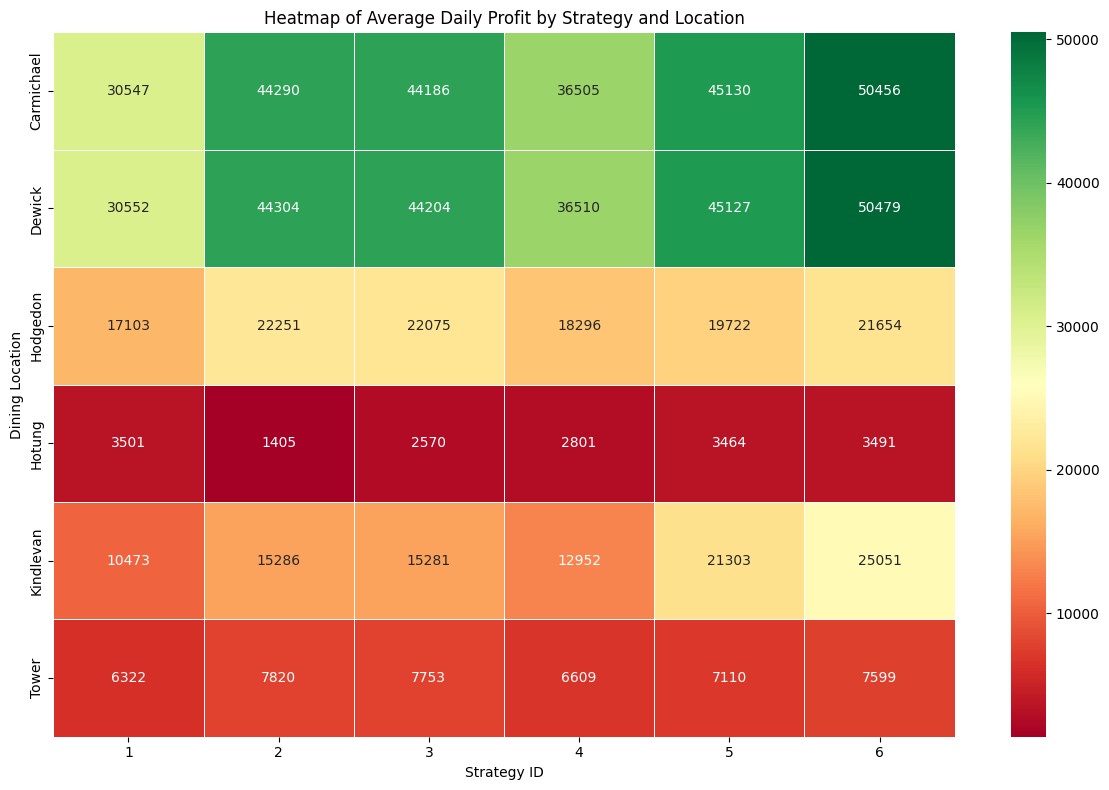

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION & CONSTANTS
# ==========================================

NUM_SIMULATIONS = 50000  # As requested in proposal
MEAL_PRICE = 18.0        # Revenue per student
TOTAL_STUDENTS = 13000   # Total population
HOURS_OPEN = 12          # 9AM to 9PM
SLOTS_PER_HOUR = 2       # 30 min slots
TOTAL_SLOTS = HOURS_OPEN * SLOTS_PER_HOUR

# Time slots indices (0 = 9:00AM, 1 = 9:30AM, ... 23 = 8:30PM)
# Rush Hours: Lunch (11:30-1:30 -> slots 5-8), Dinner (5:30-7:00 -> slots 17-19)
RUSH_SLOTS = [5, 6, 7, 8, 17, 18, 19]

# Class Break Slots (Every 3 slots as per Strategy 4)
CLASS_BREAK_SLOTS = [2, 5, 8, 11, 14, 17, 20, 23]

class DiningHall:
    def __init__(self, name, popularity, line_capacity, line_cost, base_cost, operating_hours_mask=None):
        self.name = name
        self.popularity = popularity       # Share of total students (0.0 to 1.0)
        self.line_capacity = line_capacity # Students served per slot per line
        self.line_cost = line_cost         # Cost to open one line for one slot
        self.base_cost = base_cost         # Fixed daily overhead

        # operating_hours_mask: list of 1s (open) and 0s (closed) for 24 slots
        # Default: Open all 24 slots
        if operating_hours_mask is None:
            self.operating_hours_mask = np.ones(TOTAL_SLOTS)
        else:
            self.operating_hours_mask = np.array(operating_hours_mask)

# ==========================================
# 2. DATA INITIALIZATION (ESTIMATED VALUES)
# ==========================================

# We create a base time profile (Probability of eating at time t)
# Bimodal distribution peaking at Lunch and Dinner
time_t = np.arange(TOTAL_SLOTS)
lunch_peak = np.exp(-(time_t - 7)**2 / 8)  # Peak around 12:30
dinner_peak = np.exp(-(time_t - 18)**2 / 8) # Peak around 6:00
BASE_TIME_PROFILE = (lunch_peak + dinner_peak)
BASE_TIME_PROFILE = BASE_TIME_PROFILE / BASE_TIME_PROFILE.sum() # Normalize

# Define Dining Halls based on proposal descriptions
# Note: "Short hours" for Carmichael/Dewick modeled as closing early or opening late if needed.
# Assuming standard 9-9 for simplicity unless specified.

halls = [
    # Hotung: Less popular, High Cap, High Cost
    DiningHall("Hotung", popularity=0.05, line_capacity=100, line_cost=300, base_cost=1000),

    # Tower: Less popular, Low Cap, Low Cost
    DiningHall("Tower", popularity=0.05, line_capacity=40, line_cost=100, base_cost=500),

    # Hodgedon: Popular, High Cap, High Cost
    DiningHall("Hodgedon", popularity=0.15, line_capacity=110, line_cost=320, base_cost=1500),

    # Kindlevan: Popular, Low Cap, Low Cost
    DiningHall("Kindlevan", popularity=0.15, line_capacity=45, line_cost=110, base_cost=800),

    # Dewick: Popular, Very High Cap, High Cost
    DiningHall("Dewick", popularity=0.30, line_capacity=150, line_cost=350, base_cost=2000),

    # Carmichael: Popular, Very High Cap, High Cost
    DiningHall("Carmichael", popularity=0.30, line_capacity=150, line_cost=350, base_cost=2000)
]

# ==========================================
# 3. SIMULATION ENGINE
# ==========================================

def generate_demand(hall, n_sims):
    """
    Generates a (n_sims x 24) matrix of student arrivals.
    Uses Normal distribution to add noise to the base profile.
    """
    # Base expected students per slot
    # Total Students * Hall Popularity * % eating at time t
    expected_per_slot = TOTAL_STUDENTS * hall.popularity * BASE_TIME_PROFILE

    # Create matrix
    demand_matrix = np.zeros((n_sims, TOTAL_SLOTS))

    for t in range(TOTAL_SLOTS):
        if hall.operating_hours_mask[t] == 0:
            demand_matrix[:, t] = 0
            continue

        mu = expected_per_slot[t]
        sigma = mu * 0.25 # 25% volatility (High volatility as requested for Monte Carlo value)

        # Generate random demand, ensure no negative students
        demand_matrix[:, t] = np.maximum(0, np.random.normal(mu, sigma, n_sims))

    return np.round(demand_matrix)

def run_simulation(hall, strategy_id, demand_matrix):
    """
    Runs the simulation for a specific hall and strategy.
    Returns the average profit across all simulations.
    """
    n_sims = demand_matrix.shape[0]
    lines_open = np.zeros((n_sims, TOTAL_SLOTS))

    # --- STRATEGY LOGIC ---

    if strategy_id == 1:
        # 1. Always open 1 line
        lines_open[:] = 1

    elif strategy_id == 2:
        # 2. Open 2 lines during rush hours, 1 otherwise
        lines_open[:] = 1
        lines_open[:, RUSH_SLOTS] = 2

    elif strategy_id == 3:
        # 3. Start 1. Add 1 at rush. Reduce if idle (min 1).
        # "Reduce if idle": We interpret this as checking the *previous* slot.
        # However, Strat 3 implies a reactive intra-day logic or a rule-based logic.
        # Given "Rush Hours" is a fixed time concept, we combine Rule + Reactive.

        # Base rule
        lines_open[:] = 1
        lines_open[:, RUSH_SLOTS] = 2

        # Reactive reduction: We iterate through time.
        # If t-1 was "idle" (demand < capacity of lines-1), reduce lines at t.
        # Note: Vectorizing sequential dependencies requires a loop over t.
        for t in range(1, TOTAL_SLOTS):
            prev_demand = demand_matrix[:, t-1]
            prev_lines = lines_open[:, t-1]
            prev_cap = prev_lines * hall.line_capacity

            # Idle threshold: If demand was less than 40% of capacity
            is_idle = prev_demand < (prev_cap * 0.4)

            # Logic: If it is a rush hour, we want 2, UNLESS it was idle previously.
            # If not rush, we want 1.

            # Reset to base strategy first
            current_base = 2 if t in RUSH_SLOTS else 1

            # Apply reduction logic vectorised
            # If idle and base > 1, reduce to 1.
            # (Simplification of "Reduce lines with min of 1")
            actual_lines = np.where(is_idle & (current_base > 1), current_base - 1, current_base)
            lines_open[:, t] = actual_lines

    elif strategy_id == 4:
        # 4. Always 1, add 1 at class breaks (every 3 slots). Reduce if idle.
        lines_open[:] = 1
        lines_open[:, CLASS_BREAK_SLOTS] = 2

        # Similar idle reduction logic as Strat 3
        for t in range(1, TOTAL_SLOTS):
            prev_demand = demand_matrix[:, t-1]
            prev_lines = lines_open[:, t-1]
            prev_cap = prev_lines * hall.line_capacity
            is_idle = prev_demand < (prev_cap * 0.4)

            current_base = lines_open[:, t] # 2 if class break, 1 otherwise
            actual_lines = np.where(is_idle & (current_base > 1), current_base - 1, current_base)
            lines_open[:, t] = actual_lines

    elif strategy_id == 5:
        # 5. Capacity Trigger: If current lines reach capacity at t-1, open new at t.
        # Start with 1 line at t=0
        lines_open[:, 0] = 1

        for t in range(1, TOTAL_SLOTS):
            prev_lines = lines_open[:, t-1]
            prev_capacity = prev_lines * hall.line_capacity
            prev_demand = demand_matrix[:, t-1]

            # Check if capacity was hit (demand >= 95% of capacity)
            hit_capacity = prev_demand >= (prev_capacity * 0.95)

            # If hit capacity, add line (max 5 lines to prevent infinite growth). Else maintain or drop to 1.
            # Logic: If hit cap -> lines + 1. If very idle ( < 30% cap) -> lines - 1. Else -> same.

            new_lines = prev_lines.copy()
            new_lines[hit_capacity] += 1
            new_lines[~hit_capacity & (prev_demand < prev_capacity * 0.3)] -= 1

            # Clamp between 1 and 5
            new_lines = np.clip(new_lines, 1, 5)
            lines_open[:, t] = new_lines

    elif strategy_id == 6:
        # 6. Review previous day (Oracle / History strategy).
        # Open line if capacity was hit YESTERDAY.
        # We simulate "Yesterday" by creating a separate demand matrix (random variation)
        # identifying the bottlenecks, and setting a fixed schedule for "Today".

        # 1. Simulate Yesterday
        yesterday_demand = generate_demand(hall, n_sims)
        optimized_schedule = np.ones((n_sims, TOTAL_SLOTS))

        # Determine necessary lines for yesterday to meet demand perfectly
        # implied_lines = ceiling(demand / capacity)
        implied_lines = np.ceil(yesterday_demand / hall.line_capacity)

        # Strategy says "Open 1 additional line at time slot when lines are at capacity"
        # We will assume this means we adopt the schedule that would have worked yesterday
        # Clamped to reasonable max (e.g., 4)
        optimized_schedule = np.clip(implied_lines, 1, 4)

        # Reduce if idle logic (from prompt) applied to the plan
        # If a slot requires 3 lines but previous slot required 1, maybe smooth it?
        # For strict adherence to prompt: We just use the schedule derived from history.
        lines_open = optimized_schedule

    # --- CALCULATE METRICS ---

    # Ensure lines are integers
    lines_open = lines_open.astype(int)

    # 1. Costs
    # Operational Cost = (Lines * Cost per slot) + Daily Base Cost
    # Note: Cost per line parameter is per SLOT in this model
    daily_line_costs = np.sum(lines_open * hall.line_cost, axis=1)
    total_costs = daily_line_costs + hall.base_cost

    # 2. Revenue
    # Capacity = Lines * Cap per line
    total_capacity = lines_open * hall.line_capacity

    # Served = min(Demand, Capacity)
    students_served = np.minimum(demand_matrix, total_capacity)

    # Apply Operating Hours (if closed, 0 served, 0 lines open ideally, but cost logic handles lines)
    # Mask out students served during closed hours
    students_served[:, hall.operating_hours_mask == 0] = 0

    total_revenue = np.sum(students_served * MEAL_PRICE, axis=1)

    # 3. Profit
    profit = total_revenue - total_costs

    return profit # Returns array of size n_sims

# ==========================================
# 4. MAIN EXECUTION LOOP
# ==========================================

print(f"Starting Monte Carlo Simulation...")
print(f"Simulations: {NUM_SIMULATIONS}")
print(f"Locations: {len(halls)}")
print(f"Strategies: 6")
print("-" * 50)

results = []

for hall in halls:
    print(f"Simulating {hall.name}...")

    # Generate one demand matrix per hall to be fair across strategies 1-5
    # (Strategy 6 generates its own 'yesterday' matrix internally)
    shared_demand = generate_demand(hall, NUM_SIMULATIONS)

    hall_results = {}

    for strat in range(1, 7):
        profits = run_simulation(hall, strat, shared_demand)

        avg_profit = np.mean(profits)
        std_profit = np.std(profits)
        min_profit = np.percentile(profits, 5) # 5th percentile (VaR)
        max_profit = np.percentile(profits, 95)

        results.append({
            "Dining Place": hall.name,
            "Strategy": strat,
            "Avg Profit": avg_profit,
            "Std Dev": std_profit,
            "Min Profit (5%)": min_profit,
            "Max Profit (95%)": max_profit
        })

# ==========================================
# 5. RESULTS & REPORTING
# ==========================================

df_results = pd.DataFrame(results)

# Pivot to create the Matrix of Maximum Profit Potential
pivot_df = df_results.pivot(index='Dining Place', columns='Strategy', values='Avg Profit')

print("\n=== AVERAGE DAILY PROFIT MATRIX ($) ===")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(pivot_df.round(2))

# Find Best Strategy for each
print("\n=== OPTIMAL STRATEGIES ===")
for hall in halls:
    hall_data = df_results[df_results["Dining Place"] == hall.name]
    best_row = hall_data.loc[hall_data["Avg Profit"].idxmax()]
    print(f"{hall.name}: Strategy {int(best_row['Strategy'])} (Profit: ${best_row['Avg Profit']:,.2f})")

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="RdYlGn", linewidths=.5)
plt.title("Heatmap of Average Daily Profit by Strategy and Location")
plt.ylabel("Dining Location")
plt.xlabel("Strategy ID")
plt.tight_layout()

# Save plot if needed, or just show
# plt.savefig('dining_strategy_heatmap.png')
print("\nSimulation Complete.")